In [1]:
import numpy as np
import gym
from successor_representation.environments.gridworld import GridWorld
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from copy import deepcopy
from IPython.display import clear_output
%matplotlib inline

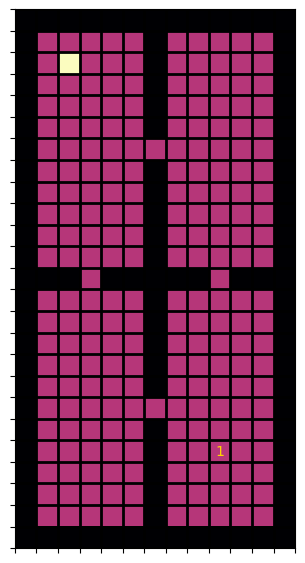

In [2]:
layout = np.loadtxt("../environments/gridworld_layouts/four_rooms.txt", comments="//", dtype=str)
env = GridWorld(layout, init_coords=[(2, 2)], terminal_coords=[(20, 9)], reward_coords={(20, 9): 1}, stochasticity=0., default_reward=-0.01)
env.reset()
env.render()

In [3]:
class SRRandomAgent:
    def __init__(self, num_valid_obs, sr_lr= 0.25, sr_gamma= 0.99, num_actions=4, seed=12):
        self.num_actions = num_actions
        self.num_valid_obs = num_valid_obs
        self.rng = np.random.default_rng(seed)
        self.sr_gamma = sr_gamma
        self.sr_lr = sr_lr
        self.sr = np.zeros((num_valid_obs, num_valid_obs), dtype=np.float32)
    def choose_action(self, obs):
        action = self.rng.integers(0, self.num_actions)
        return action
        
    def update(self, *args):
        return {}

    def update_sr(self, transition):
        obs = transition["valid_obs"]
        next_obs = transition["valid_next_obs"]
    
        kron_ohe = np.zeros(self.num_valid_obs)
        kron_ohe[obs] = 1
    
        deltas = self.sr_lr * (kron_ohe + self.sr_gamma * self.sr[next_obs] - self.sr[obs])
        self.sr[obs] += deltas
        

In [4]:
class SRQLearningAgent:
    # Assume discrete/Multidiscrete action and obs space.
    def __init__(self, num_valid_obs, num_actions=4, sr_lr=0.25, sr_gamma=0.99, gamma=0.99, lr=0.25, seed=42, min_epsilon=1e-4, max_epsilon=1., epsilon_decay=0.999):
        self.num_actions = num_actions
        self.num_valid_obs = num_valid_obs
        self.gamma = gamma
        self.lr = lr
        self.rng = np.random.default_rng(seed)
        self._qfa = defaultdict(lambda: [0. for _ in range(self.num_actions)])
        self.min_epsilon       = min_epsilon
        self.max_epsilon       = max_epsilon
        self.eps_decay_rate    = epsilon_decay
        self.epsilon = max_epsilon
        self.sr_gamma = sr_gamma
        self.sr_lr = sr_lr
        self.sr = np.zeros((num_valid_obs, num_valid_obs), dtype=np.float32)

    def update(self, batch):
        obs      = batch["obs"]
        action  = batch["action"]
        rewards  = batch["reward"]
        next_obs = batch["next_obs"]
        dones    = batch["done"]
        
        next_obs_val = max(self._qfa[next_obs])                                           
        q_target  = rewards + self.gamma * (1 - dones) * next_obs_val                       

        self._qfa[obs][action]  = self._qfa[obs][action] * (1-self.lr) + q_target * self.lr
        return self._qfa[obs][action]

        
    def choose_action(self, obs):       
        # Greedy action
        if self.rng.random() > self.epsilon:
            return self.get_greedy_action(obs)
        # Random action
        else:    
            return self.rng.integers(self.num_actions)

    def get_greedy_action(self, obs):
        q_vals     = self._qfa[obs]
        max_q      = q_vals.max(axis=-1)         
        action = self.rng.choice(np.where(q_vals == max_q)[0]) 
        return  action

    def decay_epsilon(self):
        self.epsilon *= self.eps_decay_rate
        self.epsilon = np.clip(self.epsilon, self.min_epsilon, self.max_epsilon)

        return self.epsilon
    
    def update_sr(self, transition):
        obs = transition["valid_obs"]
        next_obs = transition["valid_next_obs"]
    
        kron_ohe = np.zeros(self.num_valid_obs)
        kron_ohe[obs] = 1
    
        deltas = self.sr_lr * (kron_ohe + self.sr_gamma * self.sr[next_obs] - self.sr[obs])
        self.sr[obs] += deltas

In [5]:
def run_episodic(agent, env, num_episodes, learn_sr=True, episode_step_lim=10000):
    buffer = []
    for i in range(num_episodes):
        obs, _ = env.reset()
        for step in range(episode_step_lim):
            action = agent.choose_action(obs)
            next_obs, reward, done, *_ = env.step(action)
            transition = {
                "obs" : obs,
                "action": action,
                "reward": reward,
                "done": done,
                "next_obs": next_obs,    
                "valid_obs": env.obs_to_valid_idx(obs),
                "valid_next_obs": env.obs_to_valid_idx(next_obs)
            }
            buffer.append(transition)
            agent.update(transition)
            if learn_sr:
                agent.update_sr(transition)
            

            if done:    
                break
            else:
                obs = next_obs

    return buffer, agent

In [6]:
def run_non_episodic(agent, env, num_interactions, learn_sr=True, episode_step_lim=10000):
    buffer = []
    obs, _ = env.reset()
    for i in range(num_interactions):
        action = agent.choose_action(obs)
        next_obs, reward, done, *_ = env.step(action)
        transition = {
            "obs" : obs,
            "action": action,
            "reward": reward,
            "done": done,
            "next_obs": next_obs,
            "valid_obs": env.obs_to_valid_idx(obs),
            "valid_next_obs": env.obs_to_valid_idx(next_obs),
        }
        buffer.append(transition)
        agent.update(transition)
        if learn_sr:
            agent.update_sr(transition)

        if done or i+1 % episode_step_lim == 0:    
            obs, _ = env.reset()
        else:
            obs = next_obs

    return buffer, agent

Neumann series computation of SR:
$$\mathbf{\Psi}_\pi = \sum^\infty_{t=0}\left(\gamma \mathbf{P}_\pi\right)^t = \left(\mathbf{I}-\gamma \mathbf{P}_\pi\right)^{-1}$$

In [7]:
def compute_sr_vec(lr, gamma, buffer, num_obs):
    psi = np.zeros((num_obs, num_obs), dtype=np.float32)
    
    for transition in buffer:
        obs = transition["valid_obs"]
        next_obs = transition["valid_next_obs"]
        
        kron_ohe = np.zeros(num_obs)
        kron_ohe[obs] = 1.
        
        deltas = lr * (kron_ohe + gamma * psi[next_obs] - psi[obs])
        psi[obs] += deltas
    return psi

In [8]:
def plot_sr(env, sr, obs, title):

    fig,ax = plt.subplots()
    # Prepare the environment plot.
    env_plot = np.copy(env.grid)

    # Plot the gridworld.
    cmap = colors.ListedColormap(["white", "black", "green", "red", "yellow"])
    bounds = list(range(6))
    norm = colors.BoundaryNorm(bounds, cmap.N)
    ax.imshow(env_plot, cmap = cmap, norm = norm, zorder = 0)

    # Set up axes.
    ax.grid(which = 'major', axis = 'both', linestyle = '-', color = 'k', linewidth = 2, zorder = 1)
    ax.set_xticks(np.arange(-0.5, env.grid.shape[0] , 1))
    ax.set_xticklabels([])
    ax.set_yticks(np.arange(-0.5, env.grid.shape[1], 1))
    ax.set_yticklabels([])
    # Clear tick lines that overlap exterior of grid
    ax.tick_params(left=False, bottom=False)

    # Prepare the SR heatmap plot
    sr = list(sr[obs, :])
    res = np.copy(env.grid).astype(np.float32)
    # Prepare alpha mask
    alphas = np.zeros_like(res, dtype=np.float32)
    i_s, j_s = np.nonzero(res != -1) # Tuples of xs and ys for each occupiable state
    
    for i, (x, y) in enumerate(zip(*[i_s, j_s])):
        res[x, y] = sr[x]
        

    plt.title(title)
    sr_map = ax.imshow(res,alpha=alphas)
    fig.colorbar(sr_map)
    plt.show()


def render_sr(env, sr, obs_coord, title, figsize=(10, 7)):
        render_grid = deepcopy(env.grid)
        fig, ax = plt.subplots(figsize=figsize)
        obs_valid = env.coord_to_valid_state[obs_coord]

        # for coord, r_val in env._reward_coords.items():
        #     plt.annotate(str(r_val), coord[::-1], va="center", ha="center", c="gold" if coord in env._terminal_coords else "black")
        # # Add numbers to rewarding states.
        
        bounds = list(range(3))
        cmap = colors.ListedColormap(["white", "black", "gold"])
        norm = colors.BoundaryNorm(bounds, cmap.N)
        ax.imshow(render_grid, cmap=cmap, norm=norm, zorder=0)

        ax.grid(which = 'major', axis = 'both', linestyle = '-', color = 'k', linewidth = 2, zorder = 1)
        ax.set_xticks(np.arange(-0.5, render_grid.shape[1] , 1))
        ax.set_xticklabels([])
        ax.set_yticks(np.arange(-0.5, render_grid.shape[0], 1))
        ax.set_yticklabels([])
        ax.tick_params(left=False, bottom=False)

        sr_grid = render_grid[:, :]
        sr_vec = sr[obs_valid, :]
        opacity = np.zeros_like(sr_grid)
        i_s, j_s = np.nonzero(sr_grid != -1)
        for idx, i in enumerate(i_s):
            tmp_coord = env.valid_state_to_coord[i]
            sr_grid[i, j_s[idx]] = sr_vec[env.coord_to_valid_state[i, j_s[idx]]]
            opacity[i, j_s[idx]] = 1.

        for i in range(sr_vec.shape[0]):
            tmp_coord = env.valid_state_to_coord[i]
            sr_grid[tmp_coord] = sr_vec[i]
            opacity[tmp_coord] = 1.


        plt.title(title)
        
        sr_heat_map = ax.imshow(sr_grid, alpha=opacity, zorder=2)
        
        fig.colorbar(sr_heat_map)
        plt.show()

In [9]:
buffer, agent = run_episodic(SRQLearningAgent(env.num_valid_states), env=env, num_episodes=1000)

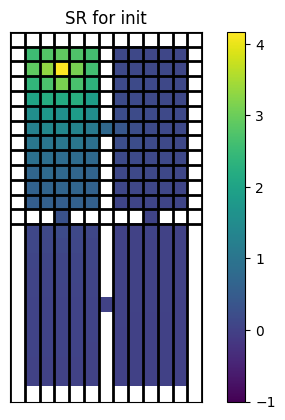

In [12]:
plot_sr(env, deepcopy(agent.sr), 12, "SR for init")